### Ticker Technical Analysis 
Uses AI based approached to analyze ticker pricing data for given date range and buy/sell signals. In this analysis, the KNN algorythm is used for supervised machine learning. 

KNN is one of the key components of AI for pattern recognition.  KNN learns from historical data to make predictions (e.g., buy/sell signals based on technical indicators). 

KNN operates based on the idea that similar data points are located close to each other in the feature space. It uses the distance between points to identify the nearest neighbors.

Training Phase -  stores all the training data points, which are then used to make predictions.

Prediction - When a new data point needs to be classified, KNN identifies the K nearest neighbors (data points) from the training set. It assigns the class that is most common among these neighbors (i.e., majority voting).

For Regression: KNN predicts the output value by averaging the values of the K nearest neighbors.

Choosing K: The parameter K is crucial. A small value of K can be sensitive to noise in the data, while a large value can smooth out the classification. Common practice involves testing multiple values of K to find the optimal one.

In [64]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [65]:
# get tomorrows date so we can use this in the yf.download as an end date

date = datetime.now() + timedelta(days=1)
fmt_date = date.strftime('%Y-%m-%d')
fmt_date

'2024-10-14'

In [66]:
# enter ticker symbol and date range to retrieve

ticker = 'ai'
start_date = '2024-01-01'
end_date =  fmt_date

In [67]:
# Fetch data for a ticker via yahoo api 

df_intra = yf.download(ticker, start_date, end_date, interval='60m', progress=False)
df = yf.download(ticker, start_date, end_date, progress=False)

In [68]:
# EMA - Calculates the Daily EMA, Intra-Day EMA & stores it to respective dataframes

def calculate_ema(fast_ema, slow_ema, data_set):
    fema = data_set['Close'].ewm(span=fast_ema, adjust=False).mean()
    sema = data_set['Close'].ewm(span=slow_ema, adjust=False).mean()
    return fema, sema

# call calculate_ema and pass in the ema values and data sets
df['EMA_A'], df['EMA_B'] = calculate_ema(5, 7, df)
df_intra['EMA_A'], df_intra['EMA_B'] = calculate_ema(5, 7, df_intra)


In [69]:
# RSI - Calulates the RSI and adds median_rsi and RSI to respective dataframes

def calculate_rsi(dataset, overbought_level, oversold_level):
    delta = dataset['Close'].diff(1)

    # Calculate the exponentially weighted moving averages of gains and losses
    gain_ewm = delta.where(delta > 0, 0).ewm(span=14, adjust=False).mean()
    loss_ewm = -delta.where(delta < 0, 0).ewm(span=14, adjust=False).mean()

    # Calculate the relative strength (RS)
    rs = gain_ewm / loss_ewm

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))

    # Compute the median between overbought and oversold levels
    median_rsi = np.median([overbought_level, oversold_level])

    dataset['Median_RSI'] = np.where(rsi > median_rsi, 'above_median', 'below_median')

    dataset['rsi'] = rsi

    return rs, rsi, median_rsi


my_rsi_values = calculate_rsi(df, 10, 90)
my_irsi_values = calculate_rsi(df_intra, 10, 90)

In [70]:
df.tail(2)

,Open,High,Low,Close,Adj Close,Volume,EMA_A,EMA_B,Median_RSI,rsi
Date,,,,,,,,,,
2024-10-10,25.50,26.370001,24.969999,26.23,26.23,3897700,25.191298,24.868741,above_median,78.765502
2024-10-11,26.09,27.475000,26.090000,27.24,27.24,5980500,25.874198,25.461556,above_median,83.636199


In [71]:
df_intra.head(5)

,Open,High,Low,Close,Adj Close,Volume,EMA_A,EMA_B,Median_RSI,rsi
Datetime,,,,,,,,,,
2024-01-02 09:30:00,28.559999,29.250000,28.150,29.195,29.195,2736834,29.195000,29.195000,below_median,NaN
2024-01-02 10:30:00,29.190001,29.730000,29.010,29.580,29.580,1960772,29.323333,29.291250,above_median,100.000000
2024-01-02 11:30:00,29.559999,29.612400,29.150,29.250,29.250,1007971,29.298889,29.280937,above_median,50.276264
2024-01-02 12:30:00,29.240101,29.520000,29.010,29.020,29.020,588236,29.205926,29.215703,below_median,35.914811
2024-01-02 13:30:00,29.019100,29.059999,28.615,28.650,28.650,693765,29.020617,29.074277,below_median,23.470303


In [72]:
# Calculate MACD and signal line
def calculate_macd(df):
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    macd_signal = macd.ewm(span=9, adjust=False).mean()
    return macd, macd_signal

df['MACD'], df['MACD_Signal'] = calculate_macd(df)
df_intra['MACD'], df_intra['MACD_Signal'] = calculate_macd(df_intra)

In [73]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,EMA_A,EMA_B,Median_RSI,rsi,MACD,MACD_Signal
Date,,,,,,,,,,,,
2024-01-02,28.559999,29.730000,28.150000,28.740000,28.740000,9224000,28.740000,28.740000,below_median,NaN,0.000000,0.000000
2024-01-03,27.799999,28.299999,27.459999,27.610001,27.610001,6665600,28.363333,28.457500,below_median,0.000000,-0.090142,-0.018028
2024-01-04,27.660000,28.200001,27.459999,27.889999,27.889999,6007700,28.205555,28.315625,below_median,22.233924,-0.137403,-0.041903
2024-01-05,27.510000,28.059999,27.200001,27.260000,27.260000,6079200,27.890370,28.051719,below_median,14.096830,-0.223122,-0.078147
2024-01-08,27.209999,28.680000,27.110001,28.570000,28.570000,7376600,28.116913,28.181289,above_median,54.260021,-0.183236,-0.099165


In [74]:
df.isnull().sum()

Open           0
High           0
Low            0
Close          0
Adj Close      0
Volume         0
EMA_A          0
EMA_B          0
Median_RSI     0
rsi            1
MACD           0
MACD_Signal    0
dtype: int64

In [75]:
df.dropna(inplace=True)
df_intra.dropna(inplace=True)

In [76]:
df.isnull().sum()

Open           0
High           0
Low            0
Close          0
Adj Close      0
Volume         0
EMA_A          0
EMA_B          0
Median_RSI     0
rsi            0
MACD           0
MACD_Signal    0
dtype: int64

In [77]:
# KNN MODEL
def create_features(df):
    df['Buy_Signal'] = ((df['EMA_A'] > df['EMA_B']) & (df['rsi'] > 20) & (df['MACD'] > df['MACD_Signal'])).astype(int)
    df['Sell_Signal'] = ((df['EMA_A'] < df['EMA_B']) & (df['rsi'] < 85) & (df['MACD'] < df['MACD_Signal'])).astype(int)
    # df['Buy_Signal'] = ((df['EMA_A'] > df['EMA_B']) & (df['MACD'] > df['MACD_Signal'])).astype(int)
    # df['Sell_Signal'] = ((df['EMA_A'] < df['EMA_B']) & (df['MACD'] < df['MACD_Signal'])).astype(int)
    # df['Buy_Signal'] = ((df['EMA_A'] > df['EMA_B'])).astype(int)
    # df['Sell_Signal'] = ((df['EMA_A'] < df['EMA_B'])).astype(int)
    df['Signal'] = df['Buy_Signal'] - df['Sell_Signal']  # Buy: 1, Sell: -1, Hold: 0
    return df

df_knn = create_features(df)

# features (X) and labels (y)
features = ['EMA_A', 'EMA_B', 'rsi', 'MACD', 'MACD_Signal']  # You can add more indicators if needed
X = df_knn[features]
y = df_knn['Signal']

# Step 3: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Step 4: Standardize the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train the KNN model
knn = KNeighborsClassifier(n_neighbors=5)  # You can tune n_neighbors
knn.fit(X_train_scaled, y_train)

# Step 6: Make predictions
y_pred = knn.predict(X_test_scaled)

# # Step 7: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Step 8: Display predicted buy/sell signals
df_test = df.iloc[len(X_train):].copy()
df_test['Predicted_Signal'] = y_pred

print("\nPredicted Buy/Sell Signals:")
df_test[['Close', 'EMA_A', 'EMA_B', 'rsi', 'MACD', 'Signal', 'Predicted_Signal']]


Accuracy: 77.97%

Predicted Buy/Sell Signals:


,Close,EMA_A,EMA_B,rsi,MACD,Signal,Predicted_Signal
Date,,,,,,,
2024-07-22,28.049999,28.614894,28.826218,36.162749,0.172932,-1,-1
2024-07-23,28.379999,28.536595,28.714663,41.575107,0.109032,-1,-1
2024-07-24,26.459999,27.844397,28.150997,26.494841,-0.095436,-1,-1
2024-07-25,26.840000,27.509598,27.823248,32.117777,-0.224231,-1,-1
2024-07-26,27.730000,27.583065,27.799936,43.746848,-0.251587,-1,-1
2024-07-29,27.400000,27.522043,27.699952,40.759474,-0.296477,-1,-1
2024-07-30,26.590000,27.211362,27.422464,34.154011,-0.392884,-1,-1
2024-07-31,26.750000,27.057575,27.254348,36.499506,-0.451176,-1,-1
2024-08-01,25.820000,26.645050,26.895761,29.461213,-0.565892,-1,-1


In [78]:
df_test.tail()

,Open,High,Low,Close,Adj Close,Volume,EMA_A,EMA_B,Median_RSI,rsi,MACD,MACD_Signal,Buy_Signal,Sell_Signal,Signal,Predicted_Signal
Date,,,,,,,,,,,,,,,,
2024-10-07,24.049999,24.299999,23.780001,24.100000,24.100000,2248300,23.711880,23.654423,above_median,60.266014,-0.025548,-0.159653,1,0,1,1
2024-10-08,24.000000,24.580000,23.920000,24.450001,24.450001,2379100,23.957920,23.853318,above_median,64.701005,0.047706,-0.118181,1,0,1,1
2024-10-09,24.580000,26.264999,24.490000,26.100000,26.100000,5377300,24.671947,24.414988,above_median,78.036237,0.236180,-0.047309,1,0,1,1
2024-10-10,25.500000,26.370001,24.969999,26.230000,26.230000,3897700,25.191298,24.868741,above_median,78.765502,0.391523,0.040457,1,0,1,1
2024-10-11,26.090000,27.475000,26.090000,27.240000,27.240000,5980500,25.874198,25.461556,above_median,83.636199,0.589338,0.150233,1,0,1,1


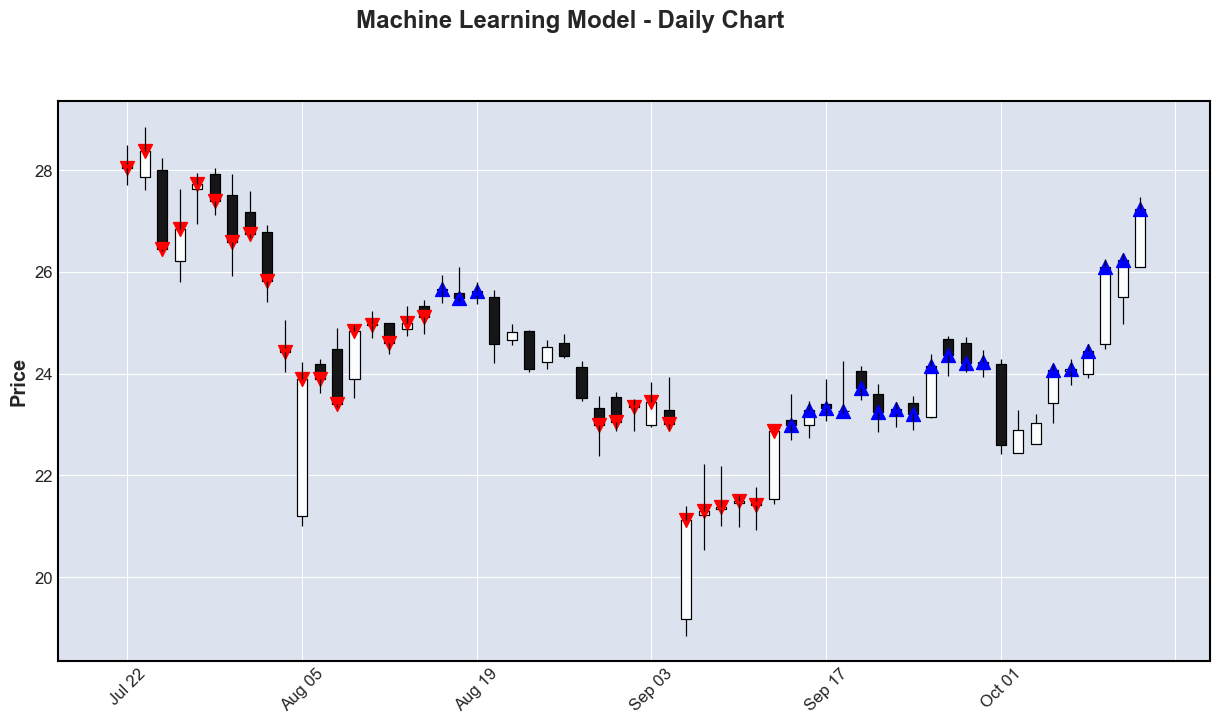

In [79]:
# Create the Signal column
df_test['Signal'] = np.where(df_test['Signal'] == 1, 1, np.where(df_test['Signal'] == -1, -1, np.nan))

# Plot the INTRA DAY candlestick & SIGNAL chart with the custom black background
mpf.plot(
    df_test,
    type='candle',
    title='Machine Learning Model - Daily Chart',
    figsize=(16, 8),
    ylabel='Price',
    warn_too_much_data=len(df_test) + 1,
    addplot=[
        # Additional plot for buy signals
        mpf.make_addplot(
            np.where(df_test['Signal'] == 1, df_test['Close'], np.nan),
            type='scatter',
            marker='^',      # Upward triangle for buy signal
            markersize=100,  # Marker size
            color='blue'     # Color for buy signals
        ),
        # Additional plot for sell signals
        mpf.make_addplot(
            np.where(df_test['Signal'] == -1, df_test['Close'], np.nan),
            type='scatter',
            marker='v',      # Downward triangle for sell signal
            markersize=100,  # Marker size
            color='red'   # Color for sell signals
        )
    ]
)

In [80]:
# -----------------------------------------------------------------------------------------------

In [81]:
df_intra.head()

,Open,High,Low,Close,Adj Close,Volume,EMA_A,EMA_B,Median_RSI,rsi,MACD,MACD_Signal
Datetime,,,,,,,,,,,,
2024-01-02 10:30:00,29.190001,29.730000,29.010000,29.580000,29.580000,1960772,29.323333,29.291250,above_median,100.000000,0.030712,0.006142
2024-01-02 11:30:00,29.559999,29.612400,29.150000,29.250000,29.250000,1007971,29.298889,29.280937,above_median,50.276264,0.028100,0.010534
2024-01-02 12:30:00,29.240101,29.520000,29.010000,29.020000,29.020000,588236,29.205926,29.215703,below_median,35.914811,0.007385,0.009904
2024-01-02 13:30:00,29.019100,29.059999,28.615000,28.650000,28.650000,693765,29.020617,29.074277,below_median,23.470303,-0.038444,0.000235
2024-01-02 14:30:00,28.639999,28.670000,28.211399,28.450001,28.450001,1123200,28.830412,28.918208,below_median,19.299475,-0.089866,-0.017786


In [82]:
# KNN MODEL
def create_features(df):
    # df['Buy_Signal'] = ((df['EMA_A'] > df['EMA_B'])).astype(int)
    # df['Sell_Signal'] = ((df['EMA_A'] < df['EMA_B'])).astype(int)
    df['Buy_Signal'] = ((df['EMA_A'] > df['EMA_B']) & (df['rsi'] > 20) & (df['MACD'] > df['MACD_Signal'])).astype(int)
    df['Sell_Signal'] = ((df['EMA_A'] < df['EMA_B']) & (df['rsi'] < 85) & (df['MACD'] < df['MACD_Signal'])).astype(int)
    df['Signal'] = df['Buy_Signal'] - df['Sell_Signal']  # Buy: 1, Sell: -1, Hold: 0
    return df

df_knn = create_features(df_intra)

# features (X) and labels (y)
features = ['EMA_A', 'EMA_B', 'rsi', 'MACD', 'MACD_Signal']  # You can add more indicators if needed
X = df_knn[features]
y = df_knn['Signal']

# Step 3: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 4: Standardize the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train the KNN model
knn = KNeighborsClassifier(n_neighbors=5)  # You can tune n_neighbors
knn.fit(X_train_scaled, y_train)

# Step 6: Make predictions
y_pred = knn.predict(X_test_scaled)

# # Step 7: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Step 8: Display predicted buy/sell signals
df_test_intra = df_intra.iloc[len(X_train):].copy()
df_test_intra['Predicted_Signal'] = y_pred

print("\nPredicted Buy/Sell Signals:")
df_test_intra[['Close', 'EMA_A', 'EMA_B', 'rsi', 'MACD', 'Signal', 'Predicted_Signal']]

Accuracy: 72.00%

Predicted Buy/Sell Signals:


,Close,EMA_A,EMA_B,rsi,MACD,Signal,Predicted_Signal
Datetime,,,,,,,
2024-08-16 14:30:00,25.570999,25.673586,25.673552,48.567671,0.200180,0,-1
2024-08-16 15:30:00,25.500000,25.615724,25.630164,44.860357,0.175479,-1,-1
2024-08-19 09:30:00,25.530001,25.587149,25.605123,46.838841,0.156520,-1,-1
2024-08-19 10:30:00,25.709999,25.628099,25.631342,57.416612,0.154242,-1,1
2024-08-19 11:30:00,25.570000,25.608733,25.616007,48.717242,0.139531,-1,-1
...,...,...,...,...,...,...,...
2024-10-11 11:30:00,26.900000,26.498975,26.362664,81.135671,0.599129,1,1
2024-10-11 12:30:00,26.980000,26.659316,26.516998,82.118188,0.625658,1,1
2024-10-11 13:30:00,27.260000,26.859544,26.702748,85.225761,0.661650,1,1


In [83]:
df_knn.head()

,Open,High,Low,Close,Adj Close,Volume,EMA_A,EMA_B,Median_RSI,rsi,MACD,MACD_Signal,Buy_Signal,Sell_Signal,Signal
Datetime,,,,,,,,,,,,,,,
2024-01-02 10:30:00,29.190001,29.730000,29.010000,29.580000,29.580000,1960772,29.323333,29.291250,above_median,100.000000,0.030712,0.006142,1,0,1
2024-01-02 11:30:00,29.559999,29.612400,29.150000,29.250000,29.250000,1007971,29.298889,29.280937,above_median,50.276264,0.028100,0.010534,1,0,1
2024-01-02 12:30:00,29.240101,29.520000,29.010000,29.020000,29.020000,588236,29.205926,29.215703,below_median,35.914811,0.007385,0.009904,0,1,-1
2024-01-02 13:30:00,29.019100,29.059999,28.615000,28.650000,28.650000,693765,29.020617,29.074277,below_median,23.470303,-0.038444,0.000235,0,1,-1
2024-01-02 14:30:00,28.639999,28.670000,28.211399,28.450001,28.450001,1123200,28.830412,28.918208,below_median,19.299475,-0.089866,-0.017786,0,1,-1


In [84]:
df_test_intra.tail()

,Open,High,Low,Close,Adj Close,Volume,EMA_A,EMA_B,Median_RSI,rsi,MACD,MACD_Signal,Buy_Signal,Sell_Signal,Signal,Predicted_Signal
Datetime,,,,,,,,,,,,,,,,
2024-10-11 11:30:00,26.709999,27.025000,26.660000,26.900000,26.900000,925081,26.498975,26.362664,above_median,81.135671,0.599129,0.538231,1,0,1,1
2024-10-11 12:30:00,26.910000,27.020000,26.740000,26.980000,26.980000,422836,26.659316,26.516998,above_median,82.118188,0.625658,0.555716,1,0,1,1
2024-10-11 13:30:00,26.980000,27.339899,26.950001,27.260000,27.260000,1020738,26.859544,26.702748,above_median,85.225761,0.661650,0.576903,1,0,1,1
2024-10-11 14:30:00,27.260000,27.475000,27.209999,27.334999,27.334999,760272,27.018029,26.860811,above_median,85.978834,0.688291,0.599180,1,0,1,1
2024-10-11 15:30:00,27.340000,27.469999,27.240000,27.240000,27.240000,892069,27.092019,26.955608,above_median,80.017661,0.693741,0.618093,1,0,1,1


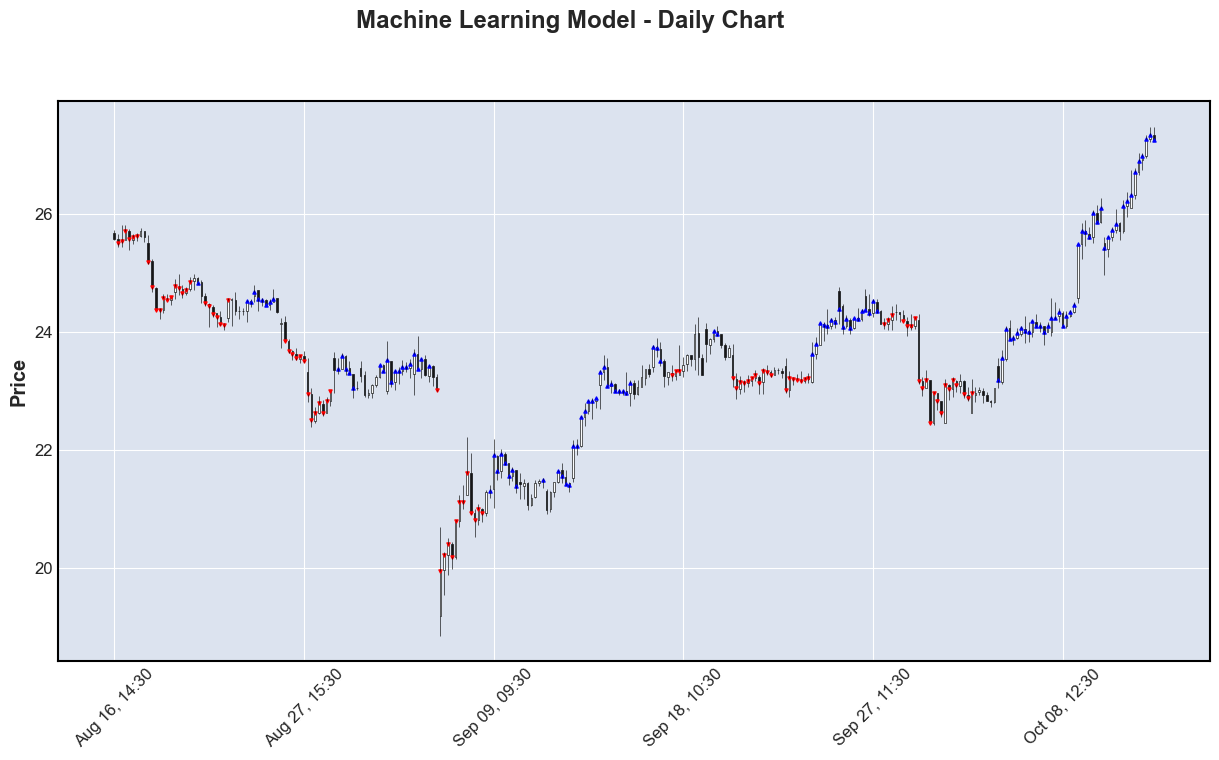

In [85]:
# Create the Signal column
df_test_intra['Signal'] = np.where(df_test_intra['Signal'] == 1, 1, np.where(df_test_intra['Signal'] == -1, -1, np.nan))

# Plot the INTRA DAY candlestick & SIGNAL chart with the custom black background
mpf.plot(
    df_test_intra,
    type='candle',
    title='Machine Learning Model - Daily Chart',
    figsize=(16, 8),
    ylabel='Price',
    warn_too_much_data=len(df_test_intra) + 1,
    addplot=[
        # Additional plot for buy signals
        mpf.make_addplot(
            np.where(df_test_intra['Signal'] == 1, df_test_intra['Close'], np.nan),
            type='scatter',
            marker='^',      # Upward triangle for buy signal
            markersize=5,  # Marker size
            color='blue'     # Color for buy signals
        ),
        # Additional plot for sell signals
        mpf.make_addplot(
            np.where(df_test_intra['Signal'] == -1, df_test_intra['Close'], np.nan),
            type='scatter',
            marker='v',      # Downward triangle for sell signal
            markersize=5,  # Marker size
            color='red'   # Color for sell signals
        )
    ]
)